# Introduction

In this notebook, we will be analyzing character and actor first names from popular television shows.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import csv
import os
%matplotlib notebook
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import mplcursors
import mpld3

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
national_df = pd.read_csv("Data/national_data.csv")
states_df = pd.read_csv("Data/states_data.csv")

### Define Function to get Wiki Data

Get character or actor names from list of main casts on wikiperdia. 

In [3]:
def extract_character_names(url, column_index, column_name=None):
    # Send a GET request to the URL
    response = requests.get(url)
    
    if response.status_code != 200:
        print("Failed to retrieve data from the URL:", url)
        return None

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table containing the character names
    table = soup.find('table', class_='wikitable')

    if table is None:
        print("Table not found in the HTML content.")
        return None

    # Initialize a list to store character names
    characters = []

    # Extract character names from the table rows
    rows = table.find_all('tr')[1:]  # Skip the header row
    for row in rows:
        # Find the cell containing the character name
        cells = row.find_all('td')
        if len(cells) >= column_index + 1:  # Ensure the row has enough cells
            character_name = cells[column_index].get_text(strip=True)
            characters.append(character_name)

    # Path to the "Data" folder
    data_folder = "Data"

    # Ensure the "Data" folder exists
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    # Write character names to a CSV file in the "Data" folder
    csv_filename = os.path.join(data_folder, f"{url.split('/')[-1]}_characters.csv")
    with open(csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        if column_name:
            writer.writerow([column_name])
        writer.writerows([[char] for char in characters])

    # Load dataframe
    df = pd.read_csv(csv_filename)
    return df

### Create Show Dataframes

In [4]:
# Wikipedia URL of Bridgerton characters
bridgerton_url = 'https://en.wikipedia.org/wiki/List_of_Bridgerton_characters'
bridgerton_df = extract_character_names(bridgerton_url, column_index=1,column_name= 'character_name')

# Wikipedia URL of Stranger Things actors
stranger_things_url = 'https://en.wikipedia.org/wiki/List_of_Stranger_Things_characters'
stranger_things_df = extract_character_names(stranger_things_url, column_index=0,column_name ='actor_name')

# Wikipedia URL of Game of Thrones actors 
game_of_thrones_url = 'https://en.wikipedia.org/wiki/List_of_Game_of_Thrones_characters'
game_of_thrones_df = extract_character_names(game_of_thrones_url, column_index=0,column_name = 'actor_name')

### Clean Bridgerton Character Names

In [5]:
#remove characters without first names on show
bridgerton_df = bridgerton_df[~bridgerton_df['character_name'].isin(['Mrs Varley','Lady Whistledown', 'Lady Danbury'])]

#Replace character name on credits to include first name
bridgerton_df['character_name'] = bridgerton_df['character_name'].replace('Lady Danbury', 'Agatha Danbury')


exact_matches_to_replace = ['Does not appear']

prefixes_to_remove = ['Lady','Mrs','King','Dowager Princess','Queen']


# Function to clean names based on criteria
def clean_names(name):
    # Replace exact matches with NaN
    if name in exact_matches_to_replace:
        return np.nan
    
    # Remove prefixes from names
    for prefix in prefixes_to_remove:
        if name.startswith(prefix):
            return name[len(prefix):].strip()
    
    return name


# Apply cleaning function to the characters column
bridgerton_df['cleaned_character_name'] = bridgerton_df['character_name'].apply(lambda x: clean_names(x))

# Get non Nan values from column
bridgerton_df = bridgerton_df[bridgerton_df['cleaned_character_name'].notna()]

# Display cleaned DataFrame
bridgerton_df.head()

,character_name,cleaned_character_name
4,Anthony Bridgerton,Anthony Bridgerton
5,Marina Thompson,Marina Thompson
6,Siena Rosso,Siena Rosso
7,Philippa Featherington,Philippa Featherington
8,Prudence Featherington,Prudence Featherington


### Define Function to Extract First Names

In [6]:
# Create function to extract first name
def extract_first_name(full_name):
    # Split the full name
    name_parts = full_name.split()
    # Check if there is at least one name
    if len(name_parts) > 0:
        # Return the first name
        return name_parts[0]
    else:
        # If no first name, return None
        return None

### Apply function to Bridgerton dataframe

In [7]:
# Apply function to create new column
bridgerton_df['character_first_name'] = bridgerton_df['cleaned_character_name'].apply(lambda x: extract_first_name(x))

# Display the updated DataFrame
bridgerton_df.head()

,character_name,cleaned_character_name,character_first_name
4,Anthony Bridgerton,Anthony Bridgerton,Anthony
5,Marina Thompson,Marina Thompson,Marina
6,Siena Rosso,Siena Rosso,Siena
7,Philippa Featherington,Philippa Featherington,Philippa
8,Prudence Featherington,Prudence Featherington,Prudence


### Define function to filter national name data for names from show

In [8]:
def filter_and_group_names(national_df, character_df, character_column):
    # Filter national_df for character names
    filtered_names_df = national_df[national_df['name'].isin(character_df[character_column])]

    # Group by name and year, summing the counts
    grouped_names_df = filtered_names_df.groupby(['name', 'year']).sum().reset_index()

    return grouped_names_df

## Analysis

### Bridgerton Analysis

<IPython.core.display.Javascript object>


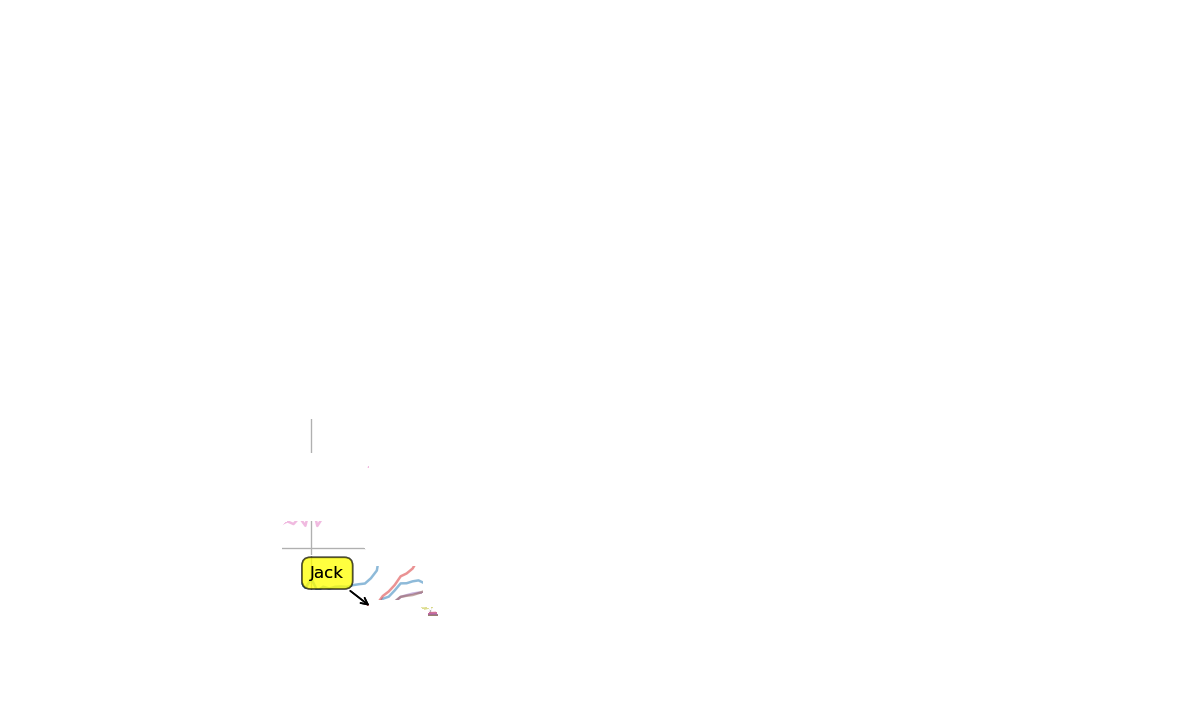

In [9]:
grouped_bridgerton_df = filter_and_group_names(national_df, bridgerton_df, 'character_first_name')

plt.figure(figsize=(10, 6))
lines = []
for name, data in grouped_bridgerton_df.groupby('name'):
    line, = plt.plot(data['year'], data['count'], label=name, alpha=0.5)
    lines.append(line)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Baby Names from Bridgerton Characters Over Time')

plt.legend(fontsize='5.5')

plt.grid(True)

# Add hover
cursor = mplcursors.cursor(hover=True)

@cursor.connect("add")
def on_hover(sel):
    sel.annotation.set_text(sel.artist.get_label())  # Display label name
    for line in lines:
        if line != sel.artist:
            line.set_alpha(0.2)  # Grey out non hover lines
        else:
            line.set_alpha(1.0)  # Highlight hover line

plt.show()

### Stranger Things Analysis

In [10]:
# Apply function to create new column
stranger_things_df['actor_first_name'] = stranger_things_df['actor_name'].apply(lambda x: extract_first_name(x))

# Display the updated DataFrame
stranger_things_df.head()

,actor_name,actor_first_name
0,Winona Ryder,Winona
1,David Harbour,David
2,Finn Wolfhard,Finn
3,Millie Bobby Brown[a],Millie
4,Gaten Matarazzo,Gaten


<IPython.core.display.Javascript object>


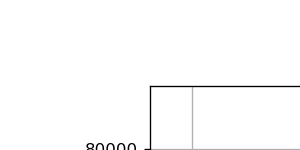

In [11]:
grouped_stranger_things_df = filter_and_group_names(national_df, stranger_things_df, 'actor_first_name')

plt.figure(figsize=(10, 6))
lines = []
for name, data in grouped_stranger_things_df.groupby('name'):
    line, = plt.plot(data['year'], data['count'], label=name, alpha=0.5)
    lines.append(line)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Baby Names from Stranger Things Actors Over Time')

plt.legend(fontsize='6')

plt.grid(True)

# Add hover
cursor = mplcursors.cursor(hover=True)

@cursor.connect("add")
def on_hover(sel):
    sel.annotation.set_text(sel.artist.get_label())  # Display label name
    for line in lines:
        if line != sel.artist:
            line.set_alpha(0.2)  # Grey out non hover lines
        else:
            line.set_alpha(1.0)  # Highlight hovered line

plt.show()

### Game of Thrones Analysis

In [12]:
# Apply function to create new column
game_of_thrones_df['actor_first_name'] = game_of_thrones_df['actor_name'].apply(lambda x: extract_first_name(x))

# Display updated DataFrame
game_of_thrones_df.head()

,actor_name,actor_first_name
0,Sean Bean,Sean
1,Mark Addy,Mark
2,Nikolaj Coster-Waldau,Nikolaj
3,Michelle Fairley,Michelle
4,Lena Headey,Lena


<IPython.core.display.Javascript object>


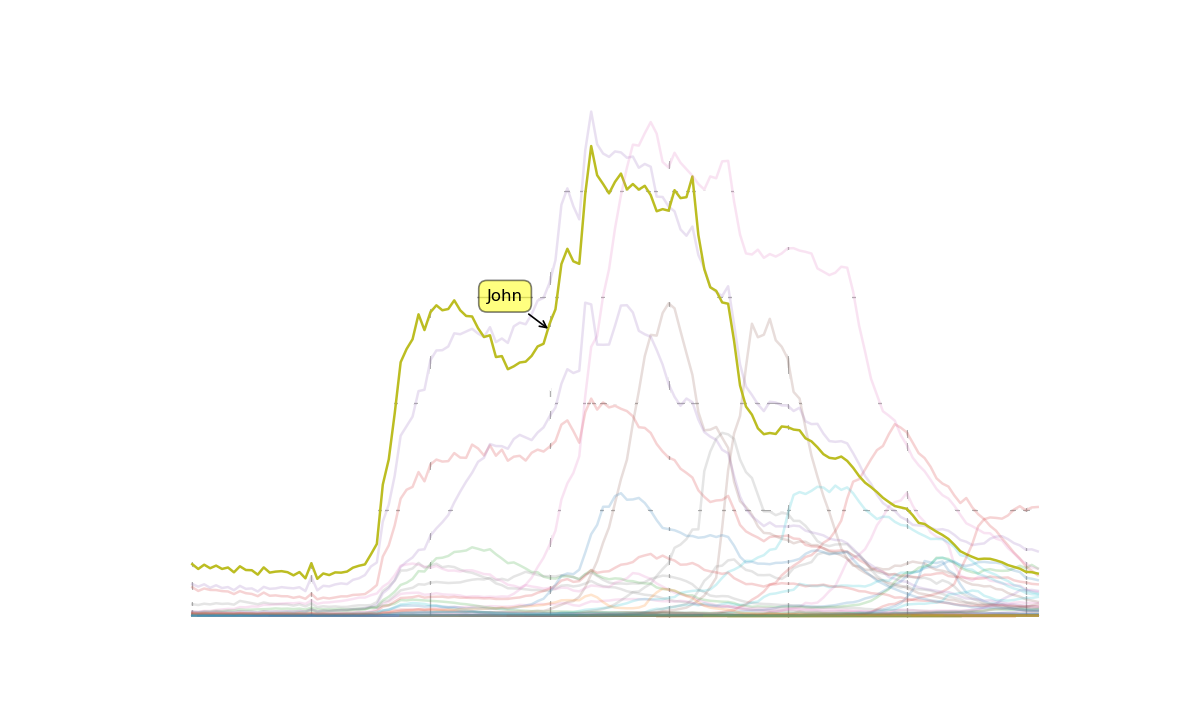

In [13]:
grouped_game_of_thrones_df = filter_and_group_names(national_df, game_of_thrones_df, 'actor_first_name')

plt.figure(figsize=(10, 6))
lines = []
for name, data in grouped_game_of_thrones_df.groupby('name'):
    line, = plt.plot(data['year'], data['count'], label=name, alpha=0.5)  # Set alpha to 0.5 to grey out lines
    lines.append(line)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Baby Names from Game of Thrones Actors Over Time')

plt.grid(True)

# Add hover
cursor = mplcursors.cursor(hover=True)

@cursor.connect("add")
def on_hover(sel):
    sel.annotation.set_text(sel.artist.get_label())  # Display label name
    for line in lines:
        if line != sel.artist:
            line.set_alpha(0.2)  # Grey out non hover lines
        else:
            line.set_alpha(1.0)  # Highlight hovered line

# Move legend outside plot
plt.legend(fontsize='5', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()